In [2]:
from u2net import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform
from umap import UMAP
from skimage.metrics import structural_similarity as ssim

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
    #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [4]:

image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
net.built=True
net.load_weights('data/saved_models/u2netP_loss=0.0027.h5')

model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [11]:
x_train, x_test, y_train, y_test = train_test_split(  all_images_rgb[:50],all_images_rgb[:50], test_size=0.2 )

In [89]:
optim=tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=True)
model.compile(optimizer=optim, loss='mse', metrics=['MAE'])
history=model.fit(x_train, y_train,
                        epochs=50,
                        batch_size=2,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/50
 48/201 [======>.......................] - ETA: 1:28 - loss: 0.0114 - MAE: 0.0772

KeyboardInterrupt: 

In [8]:

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

with strategy.scope():
    image_shape = (1024, 1024, 1)
    inputs = tf.keras.Input(shape=image_shape)
    net = U2NET(1)
    out = net(inputs)
    net.built=True
    net.load_weights('data/saved_models/u2netP_loss=0.0027.h5')

    model=tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [12]:
optim=tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.1, epsilon=1e-07, centered=True)
name='u2net_10.11.2021'
log_dir=f'data/logs/{name}'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=optim, loss='mse', metrics=['MAE'])
history=model.fit(x_train, y_train,
                  epochs=50,
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  validation_data=(x_test, x_test),
                  callbacks=[tensorboard_callback])

Epoch 1/50
40/40 [==============================] - 29s 474ms/step - loss: 0.0057 - MAE: 0.0615 - val_loss: 0.0027 - val_MAE: 0.0353
Epoch 2/50
40/40 [==============================] - 17s 414ms/step - loss: 0.0036 - MAE: 0.0386 - val_loss: 0.0026 - val_MAE: 0.0360
Epoch 3/50
40/40 [==============================] - 16s 412ms/step - loss: 0.0026 - MAE: 0.0349 - val_loss: 0.0024 - val_MAE: 0.0336
Epoch 4/50
40/40 [==============================] - 16s 412ms/step - loss: 0.0025 - MAE: 0.0343 - val_loss: 0.0023 - val_MAE: 0.0327
Epoch 5/50
40/40 [==============================] - 17s 415ms/step - loss: 0.0027 - MAE: 0.0349 - val_loss: 0.0022 - val_MAE: 0.0320
Epoch 6/50
40/40 [==============================] - 17s 416ms/step - loss: 0.0029 - MAE: 0.0355 - val_loss: 0.0022 - val_MAE: 0.0319
Epoch 7/50
40/40 [==============================] - 17s 422ms/step - loss: 0.0026 - MAE: 0.0347 - val_loss: 0.0022 - val_MAE: 0.0317
Epoch 8/50
40/40 [==============================] - 17s 417ms/step - 

KeyboardInterrupt: 

In [73]:
loss=0.0027
net.save_weights(f'u2netP_loss={loss}.h5')

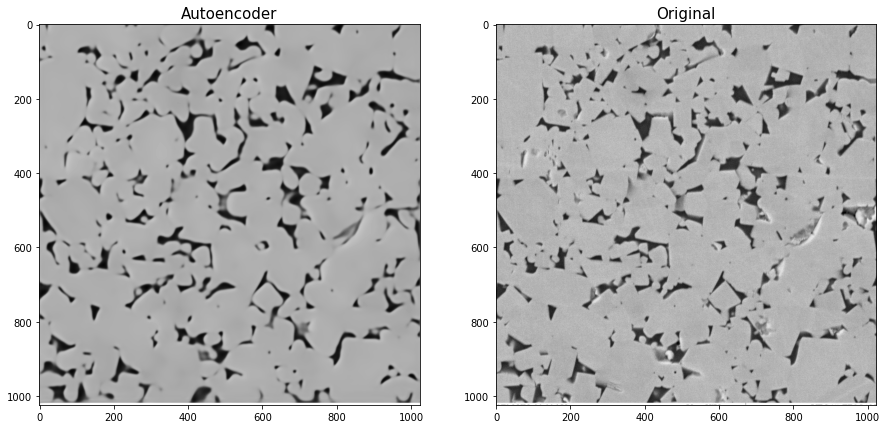

In [74]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
predict=net(tf.expand_dims(x_test[2],axis=0))[0][0]

original=x_test[2]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(predict,cmap='gray')
ax1.set_title('Autoencoder',fontsize=15)

ax2.imshow(original,cmap='gray')
ax2.set_title('Original',fontsize=15)
plt.savefig(f'autoencoder_test_loss={loss}.png')
plt.show()

In [26]:
net(tf.expand_dims(all_images_rgb[0],axis=0))[1][0].numpy().shape

(32, 32, 512)

## Visualization

In [75]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
images_embs = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        resized = transform.resize(image_gray, (1024, 1024,1))
        emb=net(tf.expand_dims(resized/255,axis=0))[1][0].numpy().flatten()
        images_embs.append(emb)

In [76]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(images_embs)

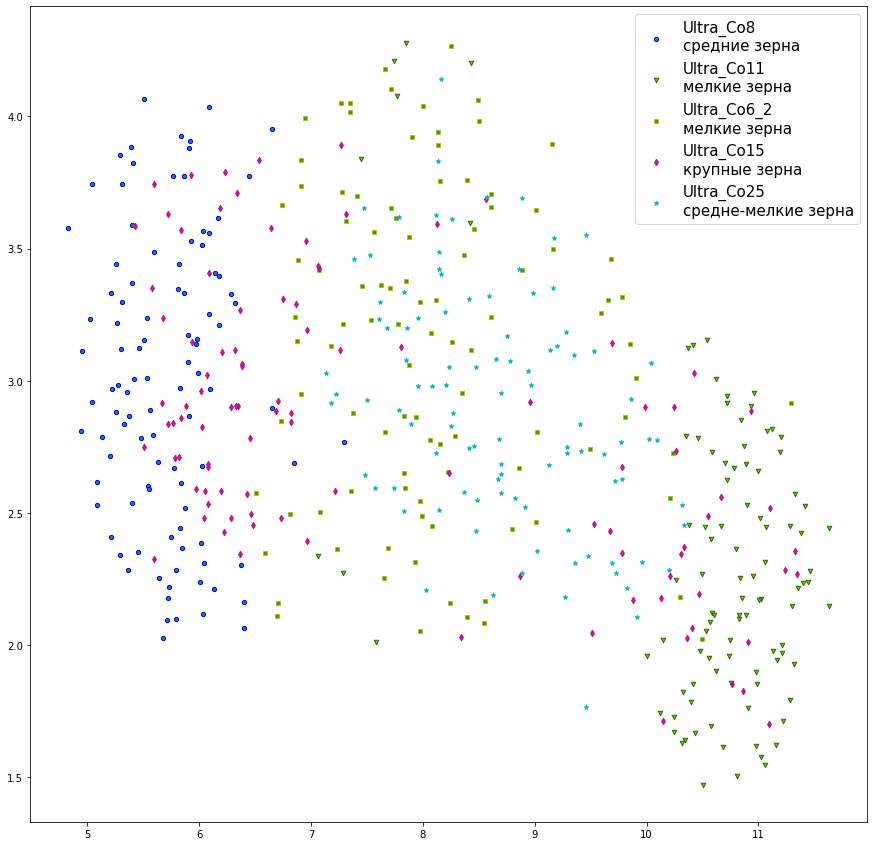

In [95]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=20

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']

colors=['b','g','y','m','c']
markers=['8','v','s','d','*',]

for i,images_list in enumerate(all_images):
    start=0
    for j in range(i):
        start+=len(all_images[j])
    end=start+len(images_list)

    ax.scatter(umaped_vct[start:end, 0], umaped_vct[start:end, 1],edgecolor=colors[i], s=size,marker=markers[i])

ax.legend(names,fontsize=15)
plt.savefig(f'embs_space_loss={loss}.png')
plt.show()